<a href="https://colab.research.google.com/github/jaejunchoe/HAIDS-Lab/blob/main/Upload_ver02_D_attn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 준비준비

In [ ]:
## 1번 실행 -> 런타임 다시 시작 -> 2번 실행 -> 3번 실행

## 1번

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (7,840 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123634 files and dire

In [ ]:
## 2번

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

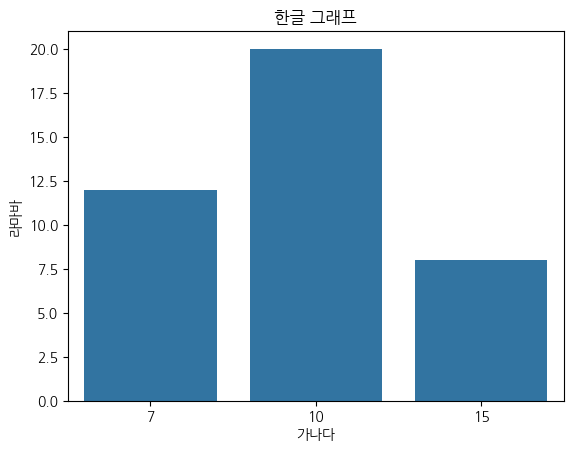

In [ ]:
## 3번

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 나눔고딕 폰트 경로 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
plt.rc('font', family=font_name)

# 그래프 그리기 예시
data = {'가나다': [10, 15, 7], '라마바': [20, 8, 12]}
df = pd.DataFrame(data)
sns.barplot(data=df, x='가나다', y='라마바')
plt.title('한글 그래프')
plt.show()


# 시작

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data_loader

Dataset과 Embedding 파일을 읽고 preprocessing

In [ ]:
import pickle
import numpy as np
import pandas as pd
import torch
from nltk import word_tokenize
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate


# Dataset Definition -> Role: Data load, Review preprocessing, Transforming embedding
class ReviewDataset(Dataset):

    # 데이터에 대한 리뷰 길이 10,000으로 제한하고, embed_size 기반으로 padding, unknown, delimiter(구분자) 데이터 설정하는 함수
    def __init__(self, csv_path, emb_path, max_len=10000, embed_size=64):
        """
        데이터셋 클래스
        :param csv_path: 전처리된 CSV 파일 경로
        :param emb_path: 단어 임베딩 파일 경로
        :param max_len: 리뷰 최대 길이
        :param embed_size: 임베딩 차원
        """
        self.dataset = pd.read_csv(csv_path, header=None, names=['userID', 'itemID', 'review', 'rating'])

        ## 단어 임베딩 로드
        with open(emb_path, 'rb') as f:
            self.word_emb = pickle.load(f)

        # 임베딩 벡터 설정
        self.pad = np.zeros(embed_size)
        self.unknown = np.random.uniform(0, 1, embed_size)
        self.delimiter = np.random.uniform(0, 1, embed_size)

        # 하이퍼파라미터
        self.max_len = max_len
        self.embed_size = embed_size


    # user와 item review에 대해 preprocessing + preprocessing된 review와 rating을 반환하는 함수
    def __getitem__(self, index):
        """
        하나의 데이터 샘플을 가져옵니다.
        """
        row = self.dataset.loc[index]
        user_id = row['userID']
        item_id = row['itemID']

        # 리뷰 데이터
        user_review = self.preprocess_review(user_id, "User")
        item_review = self.preprocess_review(item_id, "Item")

        # 평점
        rating = torch.tensor(row['rating'], dtype=torch.float)

        return torch.tensor(user_review, dtype=torch.float), \
               torch.tensor(item_review, dtype=torch.float), \
               rating


    # 데이터셋의 총 길이(샘플 개수)를 반환 -> 데이터셋의 크기 확인
    def __len__(self):
        return len(self.dataset)



    # user 또는 item id에 맞는 review를 읽고 토큰화한 뒤 word_emb에서 embedding vector로 변환하고 max_len에 맞추어 처리하는 함수
    def preprocess_review(self, entity_id, entity_type):
        """
        리뷰 파일을 로드하고 임베딩을 적용합니다.
        """
        file_path = f"data/{entity_type}/{entity_id}.tsv"                   # entity_type: user or item에 대한 문자열로 user와 item을 구분
                                                                            # entity_id: 해당 user의 id or item의 id
                                                                            # 해당 부분들은 동적으로 생성되는 구조 = file_path



        try:
            reviews = pd.read_csv(file_path, sep='\t', header=None)
        except Exception:
            return [self.pad] * self.max_len                                # 만약 파일이 존재하지 않다면, [self.pad] * self.max_len로 반환.

        total_review = []
        for review_str in reviews[0][:100]:  # 최대 100개의 리뷰 단어
            tokens = word_tokenize(review_str)
            for word in tokens:
                if word in self.word_emb:
                    total_review.append(self.word_emb[word])                # word_emb에 있는 단어에는 embedding vector로 변환
                else:
                    total_review.append(self.unknown)                       # word_emb에서 없는 단어의 경우 unknown vector로 사용
            total_review.append(self.delimiter)                             # 각 review 문장 끝날 때마다 구분 벡터로 리뷰 간의 경계선 역할을 진행




        ## 리뷰 길이 조정 (패딩 또는 자르기) -> max_len(10,000)보다 길면 자르고 짧으면 pad로 padding
        if len(total_review) < self.max_len:
            pad_len = self.max_len - len(total_review)
            total_review += [self.pad] * pad_len
        else:
            total_review = total_review[:self.max_len]

        return np.array(total_review)                                       # numpy 배열로 변환하여 반환하고 이 결과는 user or item의 review를 vector화한 max_len(10,000)의 길이 배열


# Batch 생성 시 None 데이터를 제거 -> DataLoader에서 batch를 만들 때, None 값이 포함된 데이터는 제거하는 함수
def my_collate(batch):
    """
    None 데이터를 필터링하는 Collate 함수.
    """
    batch = list(filter(lambda x: x is not None, batch))                    # batch = DataLoader로부터 전달된 데이터 리스트
    return default_collate(batch)                                           # default_collate: pytorch에서 제공하는 배치 생성 함수로, tensor 형태로 변환



# DataLoader를 생성하는 Pytorch 함수 -> ReviewDataset 클래스를 기반으로 batch 단위의 DataLoader를 반환하는 역할
def get_loader(csv_path, emb_path, batch_size=32, shuffle=True, num_workers=2):
    """
    데이터 로더 생성 함수.
    :param csv_path: 전처리된 CSV 파일 경로
    :param emb_path: 단어 임베딩 파일 경로
    """
    dataset = ReviewDataset(csv_path, emb_path)                             # ReviewDataset 객체를 생성해 데이터셋을 초기화함.
    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             num_workers=num_workers,
                             collate_fn=my_collate)                         # collate_fn: 배치 생성 시 사용할 함수이며, def my_collate를 사용한다.
    return data_loader


# 파일 경로 설정
train_path = '/content/drive/MyDrive/IDS/amaxon reviews 2023/dataset/cleaned_Transnet_T2_train.csv'
valid_path = '/content/drive/MyDrive/IDS/amaxon reviews 2023/dataset/cleaned_Transnet_T2__valid.csv'
test_path = '/content/drive/MyDrive/IDS/amaxon reviews 2023/dataset/cleaned_Transnet_T2_test.csv'
emb_path = '/content/drive/MyDrive/IDS/amaxon reviews 2023/combined_word_emb.pkl'

# 데이터 로더 생성
train_loader = get_loader(train_path, emb_path, batch_size=32, shuffle=True)
valid_loader = get_loader(valid_path, emb_path, batch_size=32, shuffle=False)
test_loader = get_loader(test_path, emb_path, batch_size=32, shuffle=False)

# 데이터 확인
for i, (user_review, item_review, rating) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print(f"User Review Tensor: {user_review.shape}")
    print(f"Item Review Tensor: {item_review.shape}")
    print(f"Rating Tensor: {rating.shape}")
    break


<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Batch 1:
User Review Tensor: torch.Size([32, 10000, 64])
Item Review Tensor: torch.Size([32, 10000, 64])
Rating Tensor: torch.Size([32])


만약 너무 느리다면? 아래의 코드로 수정



def __getitem__(self, index):
    """
    하나의 데이터 샘플을 가져옵니다.
    """
    row = self.dataset.loc[index]
    user_id = row['userID']
    item_id = row['itemID']
    
    # 리뷰 데이터
    user_review = np.array(self.preprocess_review(user_id, "User"))  # numpy 변환 추가
    item_review = np.array(self.preprocess_review(item_id, "Item"))  # numpy 변환 추가
    
    # 평점
    rating = torch.tensor(row['rating'], dtype=torch.float)
    
    return torch.tensor(user_review, dtype=torch.float), \
           torch.tensor(item_review, dtype=torch.float), \
           rating


# Model architecture

**Local vs Global**

\

Local: text(review) 내에서 국소적(지역적) 관점에서 중요한 키워드를 선택하는데에 집중하는 성향.

즉, 특정 키워드 분석하듯이 개별 단어 수준의 세부적 특성을 파악한다. \

\

Global: text(review)의 전체적인 의미를 반영해 text(review)의 전역적인 문맥을 파악하는 성향.

즉, text(review)의 전반적인 의미를 포착하는데 사용되며, 긴 리뷰에서의 noise 제거와 핵심 단어 추출에 좀 더 용이하다.


**예시: 리뷰 문장** \
"The service was excellent, and the atmosphere was cozy, but the food was overpriced and disappointing."

\\

**If) Local_Attention** \
"The service was excellent"라는 부분에 대한 attention은 "service"와 "excellent"라는 단어에 집중하고, "was"나 다른 부분은 상대적으로 덜 주목하게 됨. \
"the atmosphere was cozy"는 "atmosphere"와 "cozy"에 초점을 맞춤 \
"the food was overpriced and disappointing"는 "food", "overpriced", "disappointing" 간의 관계에 주목. \

 \
 \

**If) Golbal_Attention** \

"excellent", "cozy", "overpriced", "disappointing" 같은 감정 표현들이 문장 전체에서 서로 어떻게 연결되는지 이해하기 위해 분석함. \

-> 문장의 전반적인 톤과 주제를 판단하는 데 적합한 형태.



In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [ ]:
import torch
import torch.nn as nn


# Local 문맥을 학습하고 단어 간 가까운 상호작용 정보를 추출.
# Local 문맥에서 단어 간 상호작용을 학습하기 위해 설계된 Attention 레이어.
class LocalAttention(nn.Module):
    def __init__(self, input_size, embed_size, win_size, out_channels):
        super(LocalAttention, self).__init__()                                                                     # 'win_size = 5'를 통해 단어 주변의 문맥 정의.

        self.win_size = win_size
        self.attention_layer = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=(win_size, embed_size)),                                                   # CNN 기반으로 local 문맥의 중요도를 변환하는 Attention_layer
            nn.Sigmoid())                                                                                          # 'win_size = 5'를 고려하여 각 단어의 중요도를 0~1로 표현 -> keypoint: win_size = 5

        self.cnn = nn.Sequential(
            nn.Conv2d(1, out_channels, kernel_size=(1, embed_size)),                                               # Local 문맥을 처리하는 CNN Layer
            nn.Tanh(),
            nn.MaxPool2d((input_size, 1)))                                                                         # 문맥 정보를 집약해 최종적으로 input_size인 10,000으로 Feature map 생성


    ## input data를 padding하고 Attention layer 및 CNN에 전달하여 처리된 output 반환.

    def forward(self, x):
        # Padding dynamically to ensure compatibility
        #padding = torch.zeros(x.size(0), (self.win_size - 1) // 2, x.size(-1))
        padding = torch.zeros(x.size(0), (self.win_size - 1) // 2, x.size(-1), device=x.device)                    # Padding 처리.
        x_pad = torch.cat((padding, x, padding), 1).unsqueeze(1)

        scores = self.attention_layer(x_pad).squeeze(1)                                                            # Attention score 계산: 중요도 계산을 통한 단어별 가중치 적용
        out = torch.mul(x, scores).unsqueeze(1)
        out = self.cnn(out)                                                                                        # 최종적으로 Local 문맥 정보 변환
        return out




# Global 문맥을 학습하고 다양한 길이의 단어 간 상호작용 정보를 추출.
# Global 문맥에서 단어 간 상호작용을 학습하기 위한 Attention 레이어.
class GlobalAttention(nn.Module):
    def __init__(self, input_size, embed_size, out_channels):
        super(GlobalAttention, self).__init__()

        self.attention_layer = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=(input_size, embed_size)),                                                  # Global 단위의 중요도를 계산하는 CNN 기반의 Attention Layer
            nn.Sigmoid())                                                                                           # 입력 데이터의 길이(input_size)를 고려하여 각 단어의 중요도를 0~1로 표현 -> keypoint: 입력 데이터의 길이(input_size)


        ## cnn_1,2,3: Global 문맥의 처리를 위한 CNN Layer
        ## 나머지 구성은 동일함.


        self.cnn_1 = nn.Sequential(
            nn.Conv2d(1, out_channels, kernel_size=(2, embed_size)),
            nn.Tanh(),
            nn.MaxPool2d((input_size - 2 + 1, 1)))
        self.cnn_2 = nn.Sequential(
            nn.Conv2d(1, out_channels, kernel_size=(3, embed_size)),
            nn.Tanh(),
            nn.MaxPool2d((input_size - 3 + 1, 1)))
        self.cnn_3 = nn.Sequential(
            nn.Conv2d(1, out_channels, kernel_size=(4, embed_size)),
            nn.Tanh(),
            nn.MaxPool2d((input_size - 4 + 1, 1)))


    # CNN 필터 크기별로 Global 문맥을 처리하는 함수

    def forward(self, x):
        x = x.unsqueeze(1)
        score = self.attention_layer(x)
        out = torch.mul(x, score)
        return self.cnn_1(out), self.cnn_2(out), self.cnn_3(out)



# 사용자와 아이템 리뷰 데이터를 처리하고, 로컬 및 전역 Attention 메커니즘을 적용한 후 예측 값을 생성하는 메인 모델.
# User와 Item review를 기반으로 Local과 Global 문맥을 결합하고 최종 Rating을 예측.

class CNNDLGA(nn.Module):
    def __init__(self, input_size, embed_size=100, win_size=5, channels_local=200, channels_global=100,
                 hidden_size=500, output_size=50):
        super(CNNDLGA, self).__init__()

        self.localAttentionLayer_user = LocalAttention(input_size, embed_size, win_size, channels_local)
        self.globalAttentionLayer_user = GlobalAttention(input_size, embed_size, channels_global)
        self.localAttentionLayer_item = LocalAttention(input_size, embed_size, win_size, channels_local)
        self.globalAttentionLayer_item = GlobalAttention(input_size, embed_size, channels_global)

        # Fully Connected Layer
        # CNN에서 생성된 Feature map을 고차원 벡터로 변환하는 역할.
        self.fcLayer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),  # 입력 차원을 명시하지 않음
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )



    # LocalAttentionLayer_user와 GlobalAttentionLayer_user를 사용해 문맥 정보를 추출.
    def forward(self, x_user, x_item):
        # User side
        local_user = self.localAttentionLayer_user(x_user)
        global1_user, global2_user, global3_user = self.globalAttentionLayer_user(x_user)
        out_user = torch.cat((local_user, global1_user, global2_user, global3_user), 1).view(x_user.size(0), -1)                # CNN 출력을 연결(torch.cat)하여 Fully Conntected Layer로 전달.
        out_user = self.fcLayer(out_user)

        # Item side
        local_item = self.localAttentionLayer_item(x_item)
        global1_item, global2_item, global3_item = self.globalAttentionLayer_item(x_item)
        out_item = torch.cat((local_item, global1_item, global2_item, global3_item), 1).view(x_item.size(0), -1)                # CNN 출력을 연결(torch.cat)하여 Fully Conntected Layer로 전달.
        out_item = self.fcLayer(out_item)

        # Combine user and item representations
        out = torch.sum(torch.mul(out_user, out_item), 1)                                                                       # 두 출력 벡터를 곱(torch.mul)한 후 합산(torch.sum)하여 최종 rating 예측.
        return out


# gpu 사용

In [ ]:
print(torch.cuda.is_available())  # True면 GPU 사용 가능


True


# Training and Result 1

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import pickle
import numpy as np
from sklearn import metrics

# ================= Hyperparameters =================
input_size = 10000        # 리뷰 길이
embed_size = 64           # 임베딩 차원
num_epochs = 10           # 학습 에폭 수
batch_size = 32           # 배치 사이즈
learning_rate = 1e-4      # 학습률
hidden_size = 500         # FC 레이어 히든 사이즈
output_size = 1           # 출력 사이즈 (평점 예측)
win_size = 5              # 윈도우 크기
channels_local = 200      # LocalAttention 채널 수
channels_global = 100     # GlobalAttention 채널 수
save_path = '/content/drive/MyDrive/IDS/amaxon reviews 2023/D-attn/model save2/'  # Google Drive 저장 경로 -> validation에서의 최적 파라미터 정보가 담긴 pickle 파일을 저장하는 경로

# ================= Utility Functions =================

# def evaluation은 필요 X -> MSE 값으로 하는 걸로 변경
def evaluation(target, cf_out):
    """AUC 계산"""
    fpr, tpr, _ = metrics.roc_curve(target, cf_out)
    auc = metrics.auc(fpr, tpr)
    return auc

def to_var(x):
    """CUDA 변환 함수"""
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

# ================= Loading Data =================
print("Loading data...")

# DataLoader 생성
train_loader = get_loader(train_path, emb_path, batch_size=batch_size, shuffle=True)
valid_loader = get_loader(valid_path, emb_path, batch_size=batch_size, shuffle=False)
test_loader = get_loader(test_path, emb_path, batch_size=batch_size, shuffle=False)

print(f"train/valid/test: {len(train_loader)}/{len(valid_loader)}/{len(test_loader)}")
print("=" * 80)

Loading data...
train/valid/test: 400/50/50


In [ ]:
# ================= Model Initialization =================
model = CNNDLGA(input_size=input_size, embed_size=embed_size, win_size=win_size,
                channels_local=channels_local, channels_global=channels_global,
                hidden_size=hidden_size, output_size=output_size)

if torch.cuda.is_available():
    model.cuda()

# 손실 함수 및 최적화기
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)




In [ ]:
print("=" * 80)
print("Training Start..")

best_mse = float("inf") # 최소값을 위한 초기값 설정 -> validation에서의 최소 mse값

# ================= Training Loop =================
total_step = len(train_loader)
for epoch in range(num_epochs):
    model.train()
    batch_loss = 0.0

    for i, (user_review, item_review, labels) in enumerate(train_loader):
        # 데이터 CUDA 변환
        user_review = to_var(user_review)
        item_review = to_var(item_review)
        labels = to_var(labels)

        # Forward
        outputs = model(user_review, item_review)
        loss = criterion(outputs, labels)

        # Backward and Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()

        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], "
                  f"Loss: {batch_loss / 10:.4f}")
            batch_loss = 0.0

    # 모델 저장
    torch.save(model.state_dict(), f"{save_path}model_epoch_{epoch+1}.pkl")
    print(f"Model for epoch {epoch+1} saved.")


    print("=" * 80)
    print("Training End..")

# ================= Validation Loop =================



    print("Validation Start...")
    model.eval()
    all_outputs = []    # output_list
    all_labels = []    # target_list

    with torch.no_grad():
        for user_review, item_review, labels in valid_loader:
            user_review = to_var(user_review)
            item_review = to_var(item_review)
            labels = to_var(labels)

            outputs = model(user_review, item_review)

            all_outputs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 리스트 -> 텐서 변환
    all_outputs = torch.tensor(all_outputs)  # 리스트를 PyTorch 텐서로 변환
    all_labels = torch.tensor(all_labels)    # 리스트를 PyTorch 텐서로 변환

    # MSE 계산
    mse = torch.mean((all_labels - all_outputs) ** 2).item()
    print(f"Validation MSE: {mse:.4f}")

    print("=" * 80)
    print("Validation End..")

    if mse < best_mse:
        best_mse = mse
        torch.save(model.state_dict(), f"{save_path}best_model.pkl")
        print(f"Best model for epoch {epoch+1} saved.")

Training Start..


<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [1/10], Step [10/400], Loss: 16.6876
Epoch [1/10], Step [20/400], Loss: 15.6218
Epoch [1/10], Step [30/400], Loss: 15.8189
Epoch [1/10], Step [40/400], Loss: 15.7029
Epoch [1/10], Step [50/400], Loss: 13.9068
Epoch [1/10], Step [60/400], Loss: 13.0283
Epoch [1/10], Step [70/400], Loss: 9.9003
Epoch [1/10], Step [80/400], Loss: 7.6002
Epoch [1/10], Step [90/400], Loss: 4.7122
Epoch [1/10], Step [100/400], Loss: 2.9395
Epoch [1/10], Step [110/400], Loss: 2.7001
Epoch [1/10], Step [120/400], Loss: 2.7571
Epoch [1/10], Step [130/400], Loss: 2.6380
Epoch [1/10], Step [140/400], Loss: 2.6610
Epoch [1/10], Step [150/400], Loss: 2.5130
Epoch [1/10], Step [160/400], Loss: 2.6326
Epoch [1/10], Step [170/400], Loss: 2.5812
Epoch [1/10], Step [180/400], Loss: 2.6127
Epoch [1/10], Step [190/400], Loss: 2.4999
Epoch [1/10], Step [200/400], Loss: 2.6779
Epoch [1/10], Step [210/400], Loss: 2.6041
Epoch [1/10], Step [220/400], Loss: 2.8134
Epoch [1/10], Step [230/400], Loss: 2.5089
Epoch [1/10], 

<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Validation MSE: 2.4579
Validation End..
Best model for epoch 1 saved.


<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [2/10], Step [10/400], Loss: 2.5365
Epoch [2/10], Step [20/400], Loss: 2.6954
Epoch [2/10], Step [30/400], Loss: 2.4770
Epoch [2/10], Step [40/400], Loss: 2.3697
Epoch [2/10], Step [50/400], Loss: 2.3778
Epoch [2/10], Step [60/400], Loss: 2.5104
Epoch [2/10], Step [70/400], Loss: 2.6006
Epoch [2/10], Step [80/400], Loss: 2.5869
Epoch [2/10], Step [90/400], Loss: 2.6845
Epoch [2/10], Step [100/400], Loss: 2.6641
Epoch [2/10], Step [110/400], Loss: 2.5094
Epoch [2/10], Step [120/400], Loss: 2.5042
Epoch [2/10], Step [130/400], Loss: 2.7223
Epoch [2/10], Step [140/400], Loss: 2.4115
Epoch [2/10], Step [150/400], Loss: 2.5762
Epoch [2/10], Step [160/400], Loss: 2.5388
Epoch [2/10], Step [170/400], Loss: 2.2448
Epoch [2/10], Step [180/400], Loss: 2.7291
Epoch [2/10], Step [190/400], Loss: 2.4772
Epoch [2/10], Step [200/400], Loss: 2.6334
Epoch [2/10], Step [210/400], Loss: 2.7197
Epoch [2/10], Step [220/400], Loss: 2.4261
Epoch [2/10], Step [230/400], Loss: 2.5509
Epoch [2/10], Step [

<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Validation MSE: 2.4713
Validation End..


<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [3/10], Step [10/400], Loss: 2.2978
Epoch [3/10], Step [20/400], Loss: 2.7257
Epoch [3/10], Step [30/400], Loss: 2.8438
Epoch [3/10], Step [40/400], Loss: 2.4132
Epoch [3/10], Step [50/400], Loss: 2.5511
Epoch [3/10], Step [60/400], Loss: 2.3767
Epoch [3/10], Step [70/400], Loss: 2.8524
Epoch [3/10], Step [80/400], Loss: 2.9100
Epoch [3/10], Step [90/400], Loss: 2.7605
Epoch [3/10], Step [100/400], Loss: 2.6890
Epoch [3/10], Step [110/400], Loss: 2.4702
Epoch [3/10], Step [120/400], Loss: 2.5535
Epoch [3/10], Step [130/400], Loss: 2.7137
Epoch [3/10], Step [140/400], Loss: 2.6145
Epoch [3/10], Step [150/400], Loss: 2.7481
Epoch [3/10], Step [160/400], Loss: 2.4238
Epoch [3/10], Step [170/400], Loss: 2.3663
Epoch [3/10], Step [180/400], Loss: 2.4301
Epoch [3/10], Step [190/400], Loss: 2.6688
Epoch [3/10], Step [200/400], Loss: 2.5420
Epoch [3/10], Step [210/400], Loss: 2.3991
Epoch [3/10], Step [220/400], Loss: 2.4722
Epoch [3/10], Step [230/400], Loss: 2.3786
Epoch [3/10], Step [

<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Validation MSE: 2.4599
Validation End..


<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [4/10], Step [10/400], Loss: 2.4701
Epoch [4/10], Step [20/400], Loss: 2.6956
Epoch [4/10], Step [30/400], Loss: 2.4705
Epoch [4/10], Step [40/400], Loss: 2.6480
Epoch [4/10], Step [50/400], Loss: 2.6452
Epoch [4/10], Step [60/400], Loss: 2.4871
Epoch [4/10], Step [70/400], Loss: 2.7743
Epoch [4/10], Step [80/400], Loss: 2.4344
Epoch [4/10], Step [90/400], Loss: 2.6534
Epoch [4/10], Step [100/400], Loss: 2.4338
Epoch [4/10], Step [110/400], Loss: 2.7076
Epoch [4/10], Step [120/400], Loss: 2.6577
Epoch [4/10], Step [130/400], Loss: 2.5741
Epoch [4/10], Step [140/400], Loss: 2.5884
Epoch [4/10], Step [150/400], Loss: 2.5703
Epoch [4/10], Step [160/400], Loss: 2.3941
Epoch [4/10], Step [170/400], Loss: 2.3689
Epoch [4/10], Step [180/400], Loss: 2.3873
Epoch [4/10], Step [190/400], Loss: 2.4073
Epoch [4/10], Step [200/400], Loss: 2.7507
Epoch [4/10], Step [210/400], Loss: 2.5953
Epoch [4/10], Step [220/400], Loss: 2.6539
Epoch [4/10], Step [230/400], Loss: 2.7166
Epoch [4/10], Step [

<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Validation MSE: 2.4582
Validation End..


<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [5/10], Step [10/400], Loss: 2.4671
Epoch [5/10], Step [20/400], Loss: 2.4916
Epoch [5/10], Step [30/400], Loss: 2.6731
Epoch [5/10], Step [40/400], Loss: 2.5409
Epoch [5/10], Step [50/400], Loss: 2.6966
Epoch [5/10], Step [60/400], Loss: 2.3325
Epoch [5/10], Step [70/400], Loss: 2.7751
Epoch [5/10], Step [80/400], Loss: 2.5966
Epoch [5/10], Step [90/400], Loss: 2.7939
Epoch [5/10], Step [100/400], Loss: 2.5126
Epoch [5/10], Step [110/400], Loss: 2.5716
Epoch [5/10], Step [120/400], Loss: 2.4509
Epoch [5/10], Step [130/400], Loss: 2.3655
Epoch [5/10], Step [140/400], Loss: 2.5272
Epoch [5/10], Step [150/400], Loss: 2.6463
Epoch [5/10], Step [160/400], Loss: 2.4608
Epoch [5/10], Step [170/400], Loss: 2.5276
Epoch [5/10], Step [180/400], Loss: 2.3418
Epoch [5/10], Step [190/400], Loss: 2.4843
Epoch [5/10], Step [200/400], Loss: 2.6347
Epoch [5/10], Step [210/400], Loss: 2.7153
Epoch [5/10], Step [220/400], Loss: 2.4900
Epoch [5/10], Step [230/400], Loss: 2.2308
Epoch [5/10], Step [

<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Validation MSE: 2.4754
Validation End..


<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [6/10], Step [10/400], Loss: 2.4748
Epoch [6/10], Step [20/400], Loss: 2.3183
Epoch [6/10], Step [30/400], Loss: 2.5965
Epoch [6/10], Step [40/400], Loss: 2.4646
Epoch [6/10], Step [50/400], Loss: 2.6809
Epoch [6/10], Step [60/400], Loss: 2.6505
Epoch [6/10], Step [70/400], Loss: 2.4944
Epoch [6/10], Step [80/400], Loss: 2.5005
Epoch [6/10], Step [90/400], Loss: 2.6079
Epoch [6/10], Step [100/400], Loss: 2.7710
Epoch [6/10], Step [110/400], Loss: 2.3417
Epoch [6/10], Step [120/400], Loss: 2.3655
Epoch [6/10], Step [130/400], Loss: 2.4203
Epoch [6/10], Step [140/400], Loss: 2.2556
Epoch [6/10], Step [150/400], Loss: 2.7107
Epoch [6/10], Step [160/400], Loss: 2.6192
Epoch [6/10], Step [170/400], Loss: 2.6011
Epoch [6/10], Step [180/400], Loss: 2.7621
Epoch [6/10], Step [190/400], Loss: 2.5929
Epoch [6/10], Step [200/400], Loss: 2.7755
Epoch [6/10], Step [210/400], Loss: 2.6766
Epoch [6/10], Step [220/400], Loss: 2.4369
Epoch [6/10], Step [230/400], Loss: 2.7065
Epoch [6/10], Step [

<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Validation MSE: 2.4581
Validation End..


<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [7/10], Step [10/400], Loss: 2.6360
Epoch [7/10], Step [20/400], Loss: 2.3543
Epoch [7/10], Step [30/400], Loss: 2.6661
Epoch [7/10], Step [40/400], Loss: 2.5767
Epoch [7/10], Step [50/400], Loss: 2.6023
Epoch [7/10], Step [60/400], Loss: 2.3155
Epoch [7/10], Step [70/400], Loss: 2.7179
Epoch [7/10], Step [80/400], Loss: 2.4004
Epoch [7/10], Step [90/400], Loss: 2.3568
Epoch [7/10], Step [100/400], Loss: 2.3297
Epoch [7/10], Step [110/400], Loss: 2.4162
Epoch [7/10], Step [120/400], Loss: 2.3110
Epoch [7/10], Step [130/400], Loss: 2.5781
Epoch [7/10], Step [140/400], Loss: 2.5540
Epoch [7/10], Step [150/400], Loss: 2.4234
Epoch [7/10], Step [160/400], Loss: 2.3210
Epoch [7/10], Step [170/400], Loss: 2.6134
Epoch [7/10], Step [180/400], Loss: 2.7054
Epoch [7/10], Step [190/400], Loss: 2.5158
Epoch [7/10], Step [200/400], Loss: 2.4378
Epoch [7/10], Step [210/400], Loss: 2.4299
Epoch [7/10], Step [220/400], Loss: 2.5346
Epoch [7/10], Step [230/400], Loss: 2.5259
Epoch [7/10], Step [

<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Validation MSE: 2.4581
Validation End..


<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [8/10], Step [10/400], Loss: 2.2770
Epoch [8/10], Step [20/400], Loss: 2.4541
Epoch [8/10], Step [30/400], Loss: 2.6130
Epoch [8/10], Step [40/400], Loss: 2.7163
Epoch [8/10], Step [50/400], Loss: 2.6873
Epoch [8/10], Step [60/400], Loss: 2.6244
Epoch [8/10], Step [70/400], Loss: 2.4043
Epoch [8/10], Step [80/400], Loss: 2.4390
Epoch [8/10], Step [90/400], Loss: 2.3553
Epoch [8/10], Step [100/400], Loss: 2.7125
Epoch [8/10], Step [110/400], Loss: 2.3139
Epoch [8/10], Step [120/400], Loss: 2.6172
Epoch [8/10], Step [130/400], Loss: 2.5179
Epoch [8/10], Step [140/400], Loss: 2.4935
Epoch [8/10], Step [150/400], Loss: 2.6653
Epoch [8/10], Step [160/400], Loss: 2.4049
Epoch [8/10], Step [170/400], Loss: 2.5139
Epoch [8/10], Step [180/400], Loss: 2.6713
Epoch [8/10], Step [190/400], Loss: 2.7251
Epoch [8/10], Step [200/400], Loss: 2.3218
Epoch [8/10], Step [210/400], Loss: 2.5058
Epoch [8/10], Step [220/400], Loss: 2.7213
Epoch [8/10], Step [230/400], Loss: 2.6127
Epoch [8/10], Step [

<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Validation MSE: 2.4672
Validation End..


<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [9/10], Step [10/400], Loss: 2.4937
Epoch [9/10], Step [20/400], Loss: 2.6033
Epoch [9/10], Step [30/400], Loss: 2.5801
Epoch [9/10], Step [40/400], Loss: 2.4726
Epoch [9/10], Step [50/400], Loss: 2.5762
Epoch [9/10], Step [60/400], Loss: 2.5412
Epoch [9/10], Step [70/400], Loss: 2.5182
Epoch [9/10], Step [80/400], Loss: 2.5373
Epoch [9/10], Step [90/400], Loss: 2.5443
Epoch [9/10], Step [100/400], Loss: 2.6840
Epoch [9/10], Step [110/400], Loss: 2.5486
Epoch [9/10], Step [120/400], Loss: 2.5106
Epoch [9/10], Step [130/400], Loss: 2.8020
Epoch [9/10], Step [140/400], Loss: 2.5160
Epoch [9/10], Step [150/400], Loss: 2.6970
Epoch [9/10], Step [160/400], Loss: 2.3613
Epoch [9/10], Step [170/400], Loss: 2.5818
Epoch [9/10], Step [180/400], Loss: 2.7712
Epoch [9/10], Step [190/400], Loss: 2.4130
Epoch [9/10], Step [200/400], Loss: 2.5778
Epoch [9/10], Step [210/400], Loss: 2.4207
Epoch [9/10], Step [220/400], Loss: 2.3272
Epoch [9/10], Step [230/400], Loss: 2.2471
Epoch [9/10], Step [

<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Validation MSE: 2.4586
Validation End..


<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [10/10], Step [10/400], Loss: 2.6091
Epoch [10/10], Step [20/400], Loss: 2.4075
Epoch [10/10], Step [30/400], Loss: 2.5876
Epoch [10/10], Step [40/400], Loss: 2.5641
Epoch [10/10], Step [50/400], Loss: 2.6242
Epoch [10/10], Step [60/400], Loss: 2.5104
Epoch [10/10], Step [70/400], Loss: 2.6237
Epoch [10/10], Step [80/400], Loss: 2.7085
Epoch [10/10], Step [90/400], Loss: 2.6933
Epoch [10/10], Step [100/400], Loss: 2.6526
Epoch [10/10], Step [110/400], Loss: 2.5021
Epoch [10/10], Step [120/400], Loss: 2.4977
Epoch [10/10], Step [130/400], Loss: 2.3335
Epoch [10/10], Step [140/400], Loss: 2.5974
Epoch [10/10], Step [150/400], Loss: 2.3683
Epoch [10/10], Step [160/400], Loss: 2.3827
Epoch [10/10], Step [170/400], Loss: 2.5508
Epoch [10/10], Step [180/400], Loss: 2.3202
Epoch [10/10], Step [190/400], Loss: 2.6397
Epoch [10/10], Step [200/400], Loss: 2.5870
Epoch [10/10], Step [210/400], Loss: 2.3348
Epoch [10/10], Step [220/400], Loss: 2.6036
Epoch [10/10], Step [230/400], Loss: 2.59

<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-23-5ee29f52e361>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Validation MSE: 2.4647
Validation End..


**Example)**

Batch outputs (raw): [3.7994716 3.7994716 3.7994716 3.7994716 3.7994716] \
Batch labels: [5. 3. 5. 5. 2.]

In [ ]:
# ================= Testing Loop =================
print("=" * 80)
print("Testing Start...")
#all_outputs = []

model.load_state_dict(torch.load(f"{save_path}best_model.pkl"))
model.eval()                                                                        # Evaluation 모드로 설정

test_outputs = []
test_labels = []


test_loss = 0
num_samples = 0

with torch.no_grad():
    for user_review, item_review, labels in test_loader:
        user_review = to_var(user_review)
        item_review = to_var(item_review)
        labels = to_var(labels)

######### 모델 예측
        # Forward 예측
        outputs = model(user_review, item_review)

        test_outputs.extend(outputs.cpu().numpy())  # 예측값 저장
        test_labels.extend(labels.cpu().numpy())    # 실제값 저장

        # MSE 계산
        test_loss += torch.sum((outputs - labels) ** 2).item()
        num_samples += labels.size(0)

# 결과 계산 + MSE 도출
test_mse = test_loss / num_samples
print(f"Test MSE: {test_mse:.4f}")


# 결과 저장
with open("/content/drive/MyDrive/IDS/amaxon reviews 2023/D-attn/result_test2.pickle", "wb") as f:
    pickle.dump(all_outputs, f)

print("Testing End. Results saved to 'result_test2.pickle'.")
print("=" * 80)

Testing Start...


<ipython-input-31-b39af9b1ea1c>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{save_path}best_model.pkl"))
<ipython-input-23-5ee29f52e3

Test MSE: 2.4165
Testing End. Results saved to 'result_test2.pickle'.
